In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.9.7.29-1+cuda12.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Need to get 885 MB of archives.
After this operation, 56.3 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8-dev 8.9.7.29-1+cuda12.2 [440 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.9.7.29-1+cuda12.2 [444 MB]
Fetched 885 MB in 30s (29.8 MB/s)
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libcudnn8-dev_8.9.7.29-1+cuda12.2_amd64.deb ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
Unpacking libcudnn8-dev (8

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)
print(info)
print(info.features["label"])

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

In [ ]:
label_info = info.features['label']

# Print out the integer label and corresponding breed name for each class
for label in range(label_info.num_classes):
    print("Label:", label, "Breed Name:", label_info.int2str(label))

Label: 0 Breed Name: Abyssinian
Label: 1 Breed Name: american_bulldog
Label: 2 Breed Name: american_pit_bull_terrier
Label: 3 Breed Name: basset_hound
Label: 4 Breed Name: beagle
Label: 5 Breed Name: Bengal
Label: 6 Breed Name: Birman
Label: 7 Breed Name: Bombay
Label: 8 Breed Name: boxer
Label: 9 Breed Name: British_Shorthair
Label: 10 Breed Name: chihuahua
Label: 11 Breed Name: Egyptian_Mau
Label: 12 Breed Name: english_cocker_spaniel
Label: 13 Breed Name: english_setter
Label: 14 Breed Name: german_shorthaired
Label: 15 Breed Name: great_pyrenees
Label: 16 Breed Name: havanese
Label: 17 Breed Name: japanese_chin
Label: 18 Breed Name: keeshond
Label: 19 Breed Name: leonberger
Label: 20 Breed Name: Maine_Coon
Label: 21 Breed Name: miniature_pinscher
Label: 22 Breed Name: newfoundland
Label: 23 Breed Name: Persian
Label: 24 Breed Name: pomeranian
Label: 25 Breed Name: pug
Label: 26 Breed Name: Ragdoll
Label: 27 Breed Name: Russian_Blue
Label: 28 Breed Name: saint_bernard
Label: 29 Bree

In [ ]:
import tensorflow_datasets as tfds

# Load the Oxford-IIIT Pet dataset
dataset_name = 'oxford_iiit_pet'
train_data = tfds.load(dataset_name, split='train[:80%]', as_supervised=False)
validation_data = tfds.load(dataset_name, split='train[80%:90%]', as_supervised=False)
test_data = tfds.load(dataset_name, split='train[90%:100%]', as_supervised=False)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS1QU0G/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS1QU0G/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(features):
    # Extract image and species label
    # Adjust if the key is different

    image = features['image']
    species = features['species']
    # Continue with your image preprocessing (resize, normalize, etc.)
    # ...
    species = tf.one_hot(species, depth=2)

    return image, species

# Apply the preprocessing function to your dataset
train_data = train_data.map(preprocess)
validation_data = validation_data.map(preprocess)
test_data = test_data.map(preprocess)


In [ ]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)
augmented_validation_data = validation_data.map(augment_images)
validation_batches = augmented_validation_data.batch(32)

In [ ]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 64)       

In [ ]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(train_batches,epochs=25, validation_data = validation_batches)

Epoch 1/25
92/92 [==============================] - 16s 89ms/step - loss: 0.6027 - accuracy: 0.6790
Epoch 2/25
92/92 [==============================] - 11s 88ms/step - loss: 0.5982 - accuracy: 0.6780
Epoch 3/25
92/92 [==============================] - 13s 94ms/step - loss: 0.5963 - accuracy: 0.6783
Epoch 4/25
92/92 [==============================] - 12s 102ms/step - loss: 0.6000 - accuracy: 0.6804
Epoch 5/25
92/92 [==============================] - 12s 101ms/step - loss: 0.5949 - accuracy: 0.6793
Epoch 6/25
92/92 [==============================] - 13s 109ms/step - loss: 0.5893 - accuracy: 0.6831
Epoch 7/25
92/92 [==============================] - 11s 92ms/step - loss: 0.5906 - accuracy: 0.6824
Epoch 8/25
92/92 [==============================] - 12s 87ms/step - loss: 0.5880 - accuracy: 0.6844
Epoch 9/25
92/92 [==============================] - 12s 91ms/step - loss: 0.5899 - accuracy: 0.6872
Epoch 10/25
92/92 [==============================] - 13s 110ms/step - loss: 0.5832 - accuracy: 0.

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer  [(None, 300, 300, 3)]     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                             

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction =  np.argmax(results[0])

  class_labels = ['Cat', 'Dog']
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,np.argmax(results[0])]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  predicted_class = class_labels[prediction]
  # visualize the results
  print(f'softmax output: {results}')
  print(f"prediction: {predicted_class}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
!wget -O cat1.jpg https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
!wget -O cat2.jpg https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
!wget -O catanddog.jpg https://www.telegraph.co.uk/content/dam/news/2023/06/10/TELEMMGLPICT000296384999_16864028803870_trans_NvBQzQNjv4BqrCS9JVgwgb8GODK1xmD4xlHwtdpQwyNje2OyIL7x97s.jpeg
!wget -O dog1.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
!wget -O dog2.jpg https://www.hindustantimes.com/ht-img/img/2023/08/25/1600x900/international_dog_day_1692974397743_1692974414085.jpg

--2023-12-28 14:10:52--  https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
Resolving www.alleycat.org (www.alleycat.org)... 141.193.213.21, 141.193.213.20
Connecting to www.alleycat.org (www.alleycat.org)|141.193.213.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107329 (105K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 104.81K  --.-KB/s    in 0.01s   

2023-12-28 14:10:52 (9.52 MB/s) - ‘cat1.jpg’ saved [107329/107329]

--2023-12-28 14:10:52--  https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
Resolving i.natgeofe.com (i.natgeofe.com)... 23.54.168.19, 23.54.168.17, 2600:1408:8c00::172e:9638, ...
Connecting to i.natgeofe.com (i.natgeofe.com)|23.54.168.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060932 (1.0M) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]   1.01M  --.-KB/s    in 0.09s   

2023-12-28 14:10:52 (10.7 

1/1 [==============================] - 0s 27ms/step
softmax output: [[0.44172546 0.5582745 ]]
prediction: Dog


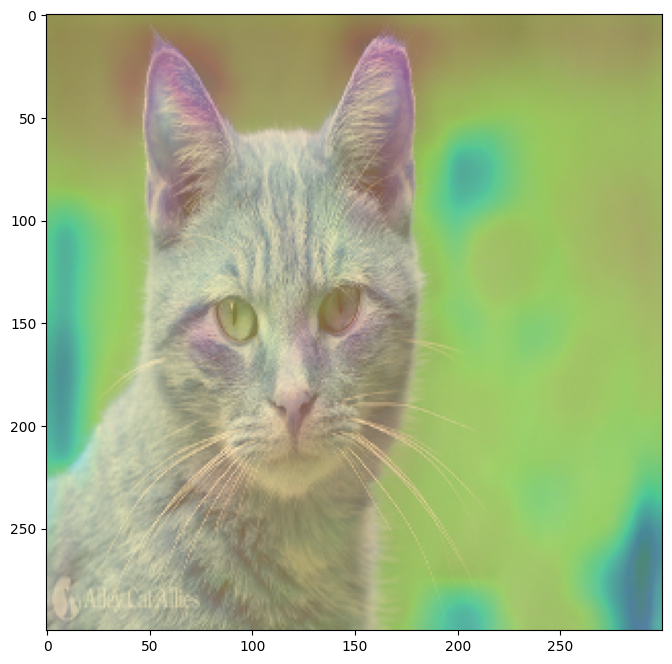

1/1 [==============================] - 0s 34ms/step
softmax output: [[0.4162505 0.5837495]]
prediction: Dog


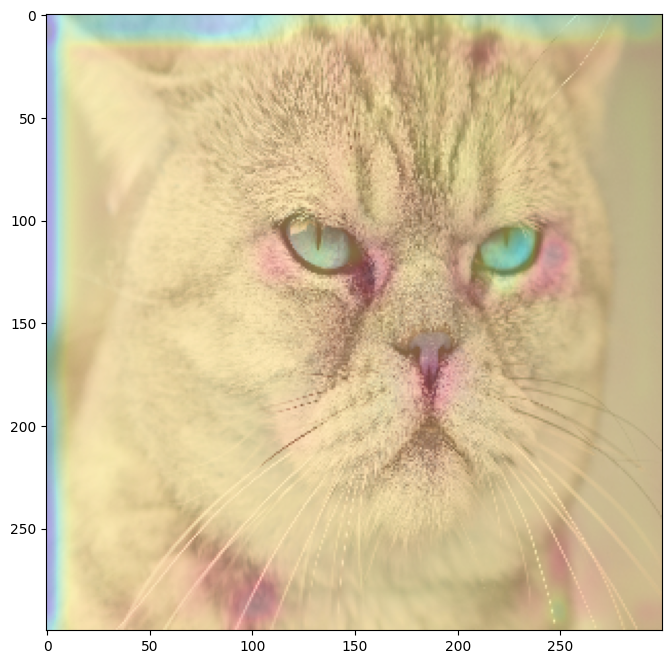

1/1 [==============================] - 0s 20ms/step
softmax output: [[0.28861582 0.7113842 ]]
prediction: Dog


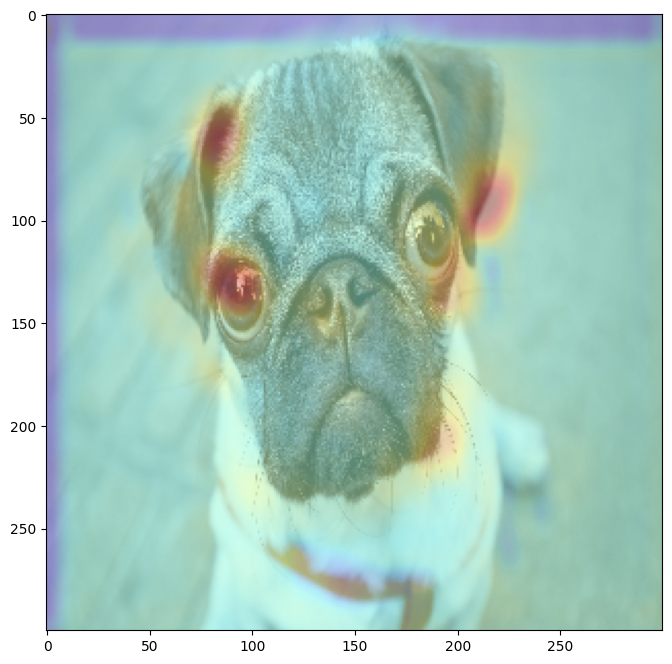

1/1 [==============================] - 0s 42ms/step
softmax output: [[0.50552773 0.4944723 ]]
prediction: Cat


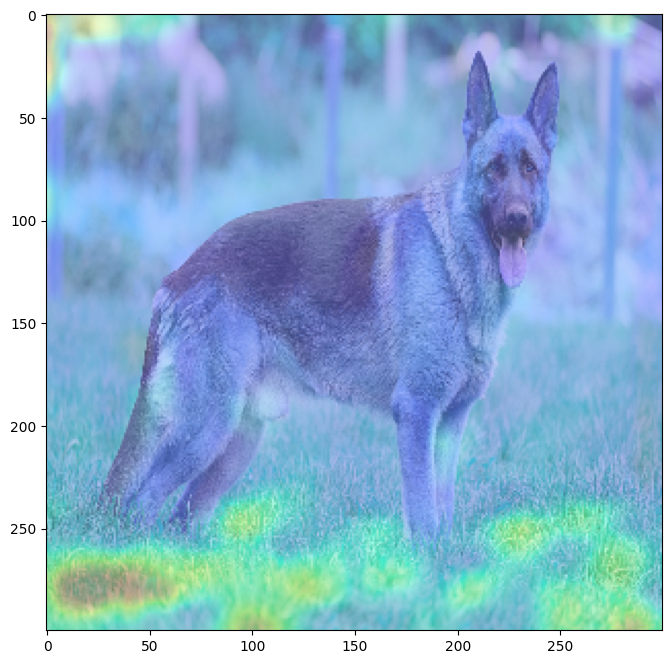

1/1 [==============================] - 0s 26ms/step
softmax output: [[0.40635774 0.59364223]]
prediction: Dog


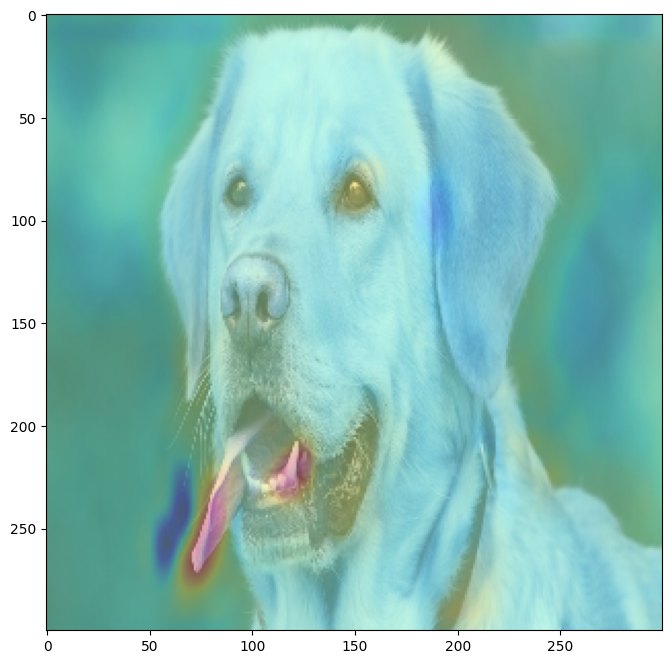

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 [==============================] - 0s 28ms/step
softmax output: [[0.18741249 0.8125875 ]]
prediction: Dog


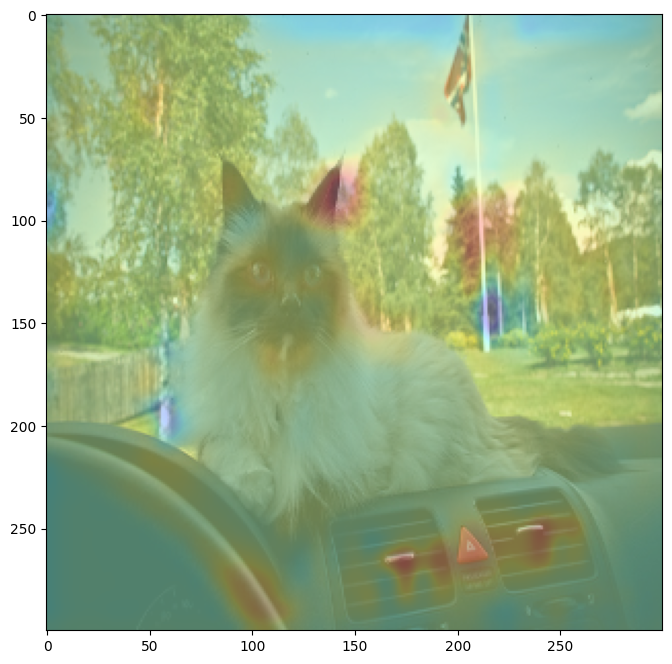

ground truth: dog
1/1 [==============================] - 0s 30ms/step
softmax output: [[0.17709729 0.82290274]]
prediction: Dog


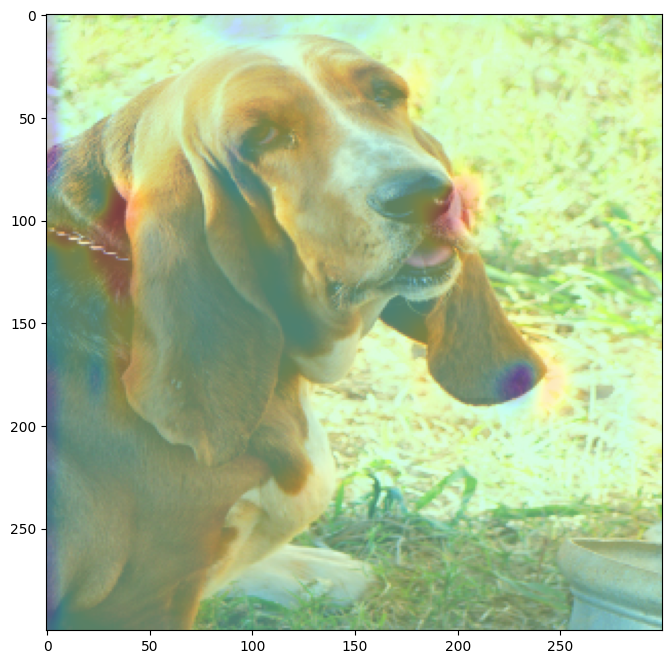

ground truth: dog
1/1 [==============================] - 0s 25ms/step
softmax output: [[0.47734    0.52265996]]
prediction: Dog


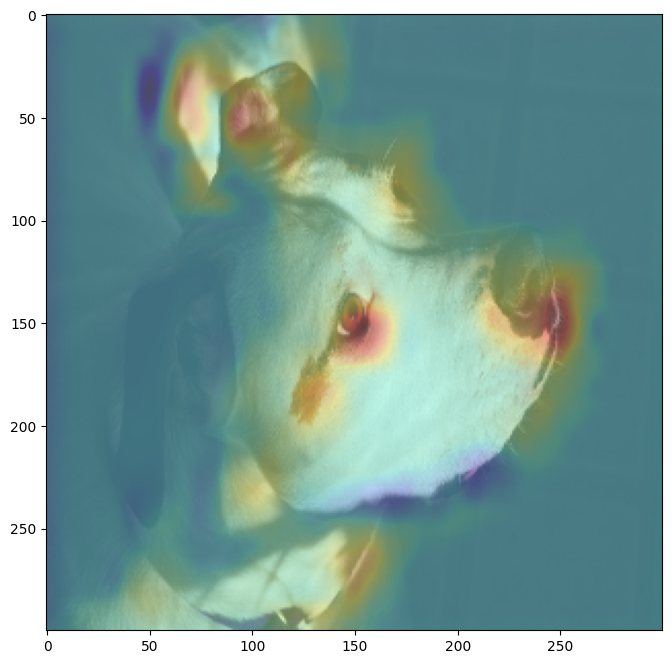

ground truth: dog
1/1 [==============================] - 0s 29ms/step
softmax output: [[0.30421498 0.695785  ]]
prediction: Dog


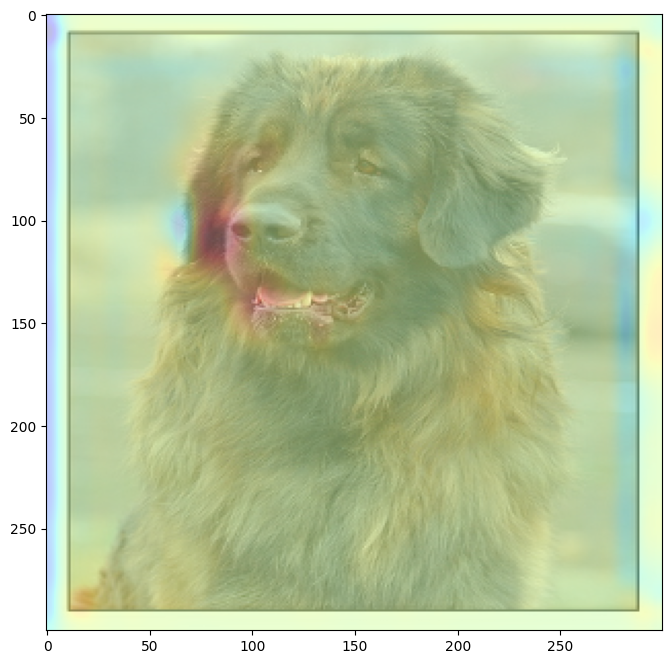

ground truth: cat
1/1 [==============================] - 0s 24ms/step
softmax output: [[0.22672541 0.7732746 ]]
prediction: Dog


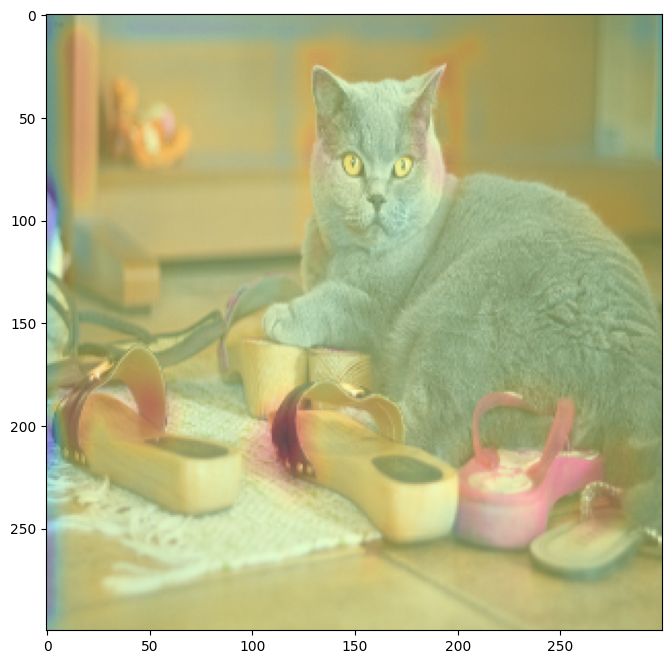

'\nfor img, lbl in test_batches.take(5):\n  print(f"ground truth: {\'dog\' if lbl else \'cat\'}")\n  features,results = cam_model.predict(img)\n  show_cam(img, features, results)'

In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)

for img, lbl in test_batches.take(5):
    # Convert lbl tensor to numpy and use the first element for condition
    lbl_np = lbl.numpy()
    ground_truth = 'cat' if lbl_np[0][0] == 1 else 'dog'  # Adjust depending on how your labels are encoded

    print(f"ground truth: {ground_truth}")
    features, results = cam_model.predict(img)
    show_cam(img, features, results)
"""
for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)"""